In [6]:
import matplotlib.pyplot as plt
import numpy as np

class OHLC():
    """
    plot the OHLC charts
    """
    def __init__(self,
                 data,
                 ma_cols=['5_day_MA', '20_day_MA', '60_day_MA'],
                 ):
        self.data = data.copy()
        self.feat_cols = ['open', 'high', 'low', 'close'] + ma_cols
        self.ma_cols = ma_cols

    def standardize_data(self):
        df = self.data.copy()
        # df = df.assign(date = pd.to_datetime(df.date,format = "%Y%m%d"))
        df = df[['code', 'date', 'open', 'high', 'low', 'close', 'volume', 'amount', 'ret_f1', 'ret_cf2', 'ret_cf3',
                 'ret_cf4', 'ret_cf5', 'ret_cf10', 'ret_cf20', 'ret_cf60', '5_day_MA', '20_day_MA', '60_day_MA']]
        df.reset_index(inplace=True)
        # we normalize the open price to be one at the initial date
        scale = df.loc[0, 'open']
        for col in ['open', 'high', 'close', 'low', '5_day_MA', '20_day_MA', '60_day_MA']:
            df[col] = df[col] / scale
        # we normalize the volume to be one at the initial date
        scale = df.loc[0, 'volume']
        df['volume'] = df['volume'] / scale
        return df

    def plot(self):
        df = self.data.reset_index(drop=True).copy()
        high = df[['high'] + self.ma_cols].values.max()
        low = df[['low'] + self.ma_cols].values.min()
        for col in self.feat_cols:
            df[col] = (df[col] - low) / (high - low) * 76
            df[col] = df[col].round(0).astype(int) + 19

        df['volume'] = df['volume'] / df['volume'].max() * 19
        df['volume'] = df['volume'].round(0).astype(int)

        plot = np.zeros((96, 180))
        for idx, row in df.iterrows():
            plot[row['open'], idx*3] = 1
            plot[row['low']:row['high']+1, idx*3+1] = 1
            plot[row['close']:row['close']+1, idx*3+2] = 1
            plot[:row['volume']+1, idx*3+1] = 1

            for col in self.ma_cols:
                pre_ma = df.loc[idx-1, col] if idx >= 1 else df.loc[idx, col]
                next_ma = df.loc[idx+1, col] if idx <= len(df)-2 else df.loc[idx, col]

                plot[(row[col] + pre_ma)//2, idx*3] = 1
                plot[row[col], idx*3+1] = 1
                plot[(row[col] + next_ma)//2, idx*3+2] = 1

        # plot *= 255
        plot = plot[::-1, :]  # reversion

        return plot  # np.array with shape (96,180)
    

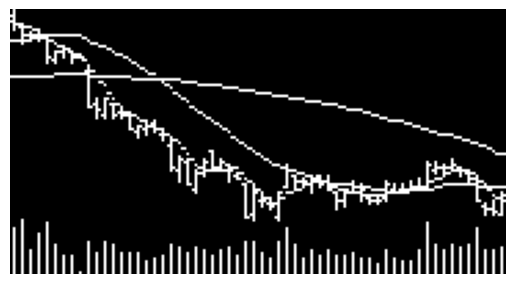

In [12]:
import pandas as pd
# 60 days, 180 pixels on xaxis (3 per date)
df = pd.read_csv('./sample_data.csv').iloc[:, 1:].dropna().iloc[:60]
ohlc = OHLC(df)
fig = ohlc.plot()
plt.imshow(fig, cmap='gray')
plt.axis('off')
plt.show()